# Installing Dependencies and Load

%pip list

In [1]:
import tensorflow as tf
import os
import cv2

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_dir = 'C:\\Users\\marce\\OneDrive\\Documentos\\Code\\Dataset\\Train'
val_dir = 'C:\\Users\\marce\\OneDrive\\Documentos\\Code\\Dataset\\Val'

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
os.listdir(train_dir)

['banana',
 'batata',
 'cebola',
 'laranja pera',
 'maca',
 'nenhum',
 'pera',
 'tomate']

## Remove corrupted image files

data_dir = 'C:\\Users\\marce\\OneDrive\\Documentos\\Code\\Dataset'
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [7]:
SIZE = 384
BATCH_SIZE = 16
IMG_SIZE = (SIZE, SIZE)
IMG_SHAPE = IMG_SIZE + (3,)

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, batch_size=BATCH_SIZE, image_size=(SIZE, SIZE), crop_to_aspect_ratio=True)
val_data = tf.keras.utils.image_dataset_from_directory(val_dir, batch_size=BATCH_SIZE, image_size=(SIZE, SIZE), crop_to_aspect_ratio=True)

Found 9390 files belonging to 8 classes.
Found 3932 files belonging to 8 classes.


In [9]:
class_names = sorted(os.listdir(train_dir))
print('Classes:', class_names)

Classes: ['banana', 'batata', 'cebola', 'laranja pera', 'maca', 'nenhum', 'pera', 'tomate']


train_data = train_data.map(lambda x,y: (x/255, y))
val_data = val_data.map(lambda x,y: (x/255, y))

In [10]:
scaled_iterator = train_data.as_numpy_iterator()

In [11]:
batch = scaled_iterator.next()

In [12]:
print(f'Images data min: {np.min(batch[0][1])}, max: {np.max(batch[0][1])}')

Images data min: 0.0, max: 253.50732421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


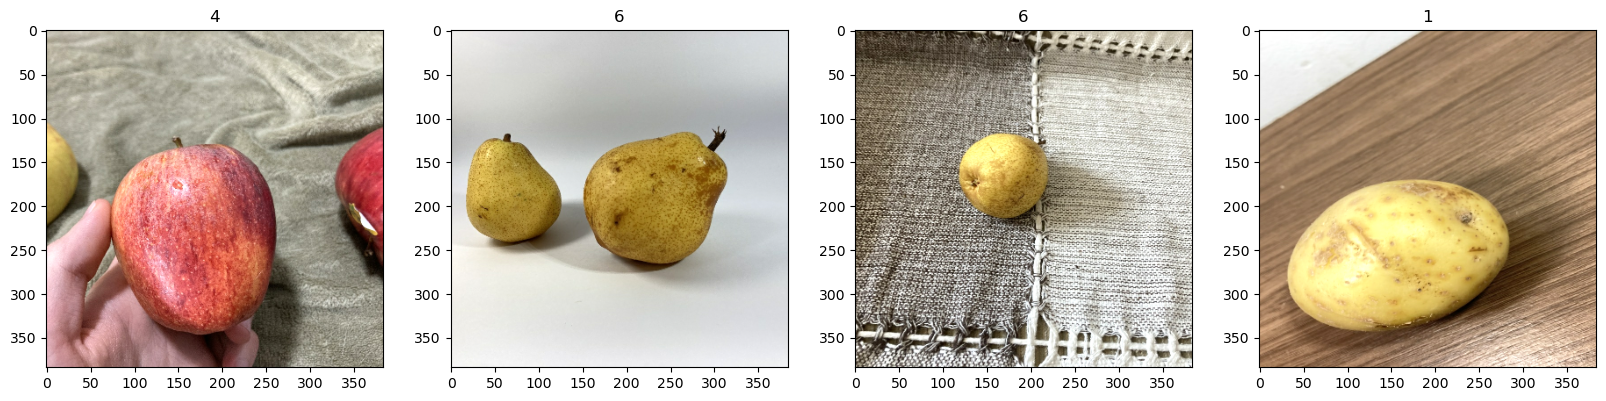

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]/225):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Model

In [ ]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [14]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(input_shape=IMG_SHAPE,
                                                                   include_top=False,
                                                                   weights='imagenet')

In [57]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
model = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=(SIZE, SIZE, 3)),
    # img_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [17]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 20,341,608
Trainable params: 10,248
Non-trainable params: 20,331,360
_________________________________________________________________


In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

923s 6s/step - loss: 1.7835 - accuracy: 0.3401 - val_loss: 2.0936 - val_accuracy: 0.1907

In [23]:
import datetime

start_time = datetime.datetime.now()

EPOCHS = 10

history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data)

end_time = datetime.datetime.now()
formatted_time = str(end_time - start_time).split(".")[0]
print("Tempo de execução:", formatted_time, '\n\n')

Epoch 1/10


587/587 [==============================] - 886s 2s/step - loss: 0.0510 - accuracy: 0.9917 - val_loss: 0.2836 - val_accuracy: 0.9087
Epoch 2/10
587/587 [==============================] - 885s 2s/step - loss: 0.0471 - accuracy: 0.9906 - val_loss: 0.2818 - val_accuracy: 0.9090
Epoch 3/10
587/587 [==============================] - 884s 2s/step - loss: 0.0414 - accuracy: 0.9929 - val_loss: 0.2737 - val_accuracy: 0.9115
Epoch 4/10
587/587 [==============================] - 883s 2s/step - loss: 0.0389 - accuracy: 0.9924 - val_loss: 0.2732 - val_accuracy: 0.9107
Epoch 5/10
587/587 [==============================] - 883s 2s/step - loss: 0.0365 - accuracy: 0.9930 - val_loss: 0.2688 - val_accuracy: 0.9112
Epoch 6/10
587/587 [==============================] - 886s 2s/step - loss: 0.0348 - accuracy: 0.9939 - val_loss: 0.2639 - val_accuracy: 0.9130
Epoch 7/10
587/587 [==============================] - 845s 1s/step - loss: 0.0307 - accuracy: 0.9950 - val_loss: 0.2645 - val_accuracy: 0.9135
Epoch 8/10

In [24]:
loss0, accuracy0 = model.evaluate(val_data)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

246/246 [==============================] - 239s 968ms/step - loss: 0.2545 - accuracy: 0.9171
initial loss: 0.25
initial accuracy: 0.92


In [25]:
model_name = '2EffNet_' + str(len(class_names)) + '_' + str(SIZE)
model.save(model_name)

INFO:tensorflow:Assets written to: 2EffNet_8_384\assets


INFO:tensorflow:Assets written to: 2EffNet_8_384\assets


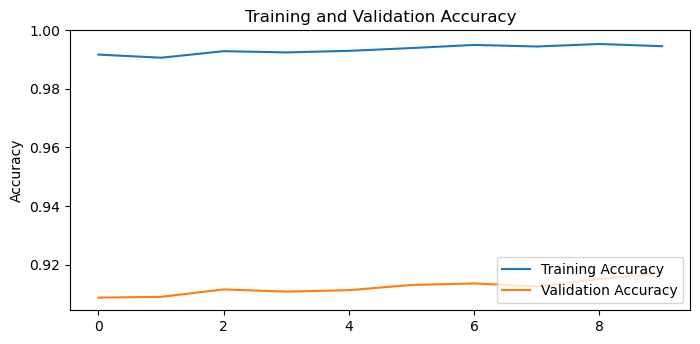

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

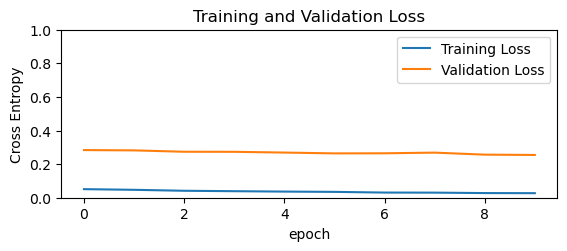

# Fine-tunning

In [59]:
for layer in base_model.layers:
    if layer.name.startswith("block6o") or layer.name.startswith("top"):
        if layer.name.find("bn") == -1:
            layer.trainable = True
            print(layer.name, '\t', layer.trainable)
        else:
            print('--', layer.name, '\t', layer.trainable)
    else:
        print(layer.name, '\t', layer.trainable)

input_1 	 False
rescaling 	 False
stem_conv 	 False
stem_bn 	 False
stem_activation 	 False
block1a_project_conv 	 False
block1a_project_bn 	 False
block1a_project_activation 	 False
block1a_add 	 False
block1b_project_conv 	 False
block1b_project_bn 	 False
block1b_project_activation 	 False
block1b_drop 	 False
block1b_add 	 False
block2a_expand_conv 	 False
block2a_expand_bn 	 False
block2a_expand_activation 	 False
block2a_project_conv 	 False
block2a_project_bn 	 False
block2b_expand_conv 	 False
block2b_expand_bn 	 False
block2b_expand_activation 	 False
block2b_project_conv 	 False
block2b_project_bn 	 False
block2b_drop 	 False
block2b_add 	 False
block2c_expand_conv 	 False
block2c_expand_bn 	 False
block2c_expand_activation 	 False
block2c_project_conv 	 False
block2c_project_bn 	 False
block2c_drop 	 False
block2c_add 	 False
block2d_expand_conv 	 False
block2d_expand_bn 	 False
block2d_expand_activation 	 False
block2d_project_conv 	 False
block2d_project_bn 	 False
block2d

In [60]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 20,341,608
Trainable params: 1,336,392
Non-trainable params: 19,005,216
_________________________________________________________________


In [62]:
fine_learning_rate = 0.00002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [63]:
start_time = datetime.datetime.now()

EPOCHS = 10

history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data)

end_time = datetime.datetime.now()
formatted_time = str(end_time - start_time).split(".")[0]
print("Tempo de execução:", formatted_time, '\n\n')

Epoch 1/10
587/587 [==============================] - 5496s 9s/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.3455 - val_accuracy: 0.8960
Epoch 2/10
587/587 [==============================] - 6036s 10s/step - loss: 0.0080 - accuracy: 0.9982 - val_loss: 0.2612 - val_accuracy: 0.9194
Epoch 3/10
587/587 [==============================] - 7768s 13s/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.2593 - val_accuracy: 0.9201
Epoch 4/10
587/587 [==============================] - 4999s 9s/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.2456 - val_accuracy: 0.9301
Epoch 5/10
587/587 [==============================] - 4826s 8s/step - loss: 0.0027 - accuracy: 0.9997 - val_loss: 0.2619 - val_accuracy: 0.9278
Epoch 6/10
587/587 [==============================] - 4834s 8s/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.2339 - val_accuracy: 0.9374
Epoch 7/10
587/587 [==============================] - 4836s 8s/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.2377 - val_accurac

In [64]:
model_name = 'Fine-2EffNet_' + str(len(class_names)) + '_' + str(SIZE)
model.save(model_name)

INFO:tensorflow:Assets written to: Fine-2EffNet_8_384\assets


INFO:tensorflow:Assets written to: Fine-2EffNet_8_384\assets


In [65]:
start_time = datetime.datetime.now()

EPOCHS = 5

history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data)

end_time = datetime.datetime.now()
formatted_time = str(end_time - start_time).split(".")[0]
print("Tempo de execução:", formatted_time, '\n\n')

model_name = 'Fine-215EffNet_' + str(len(class_names)) + '_' + str(SIZE)
model.save(model_name)

Epoch 1/5
587/587 [==============================] - 4439s 8s/step - loss: 6.2729e-04 - accuracy: 1.0000 - val_loss: 0.2587 - val_accuracy: 0.9296
Epoch 2/5
587/587 [==============================] - 4438s 8s/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.2756 - val_accuracy: 0.9260
Epoch 3/5
587/587 [==============================] - 4436s 8s/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.3057 - val_accuracy: 0.9204
Epoch 4/5
587/587 [==============================] - 4451s 8s/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.2242 - val_accuracy: 0.9413
Epoch 5/5
587/587 [==============================] - 4453s 8s/step - loss: 9.0970e-04 - accuracy: 0.9999 - val_loss: 0.2399 - val_accuracy: 0.9400
Tempo de execução: 6:10:16 




INFO:tensorflow:Assets written to: Fine-215EffNet_8_384\assets


INFO:tensorflow:Assets written to: Fine-215EffNet_8_384\assets


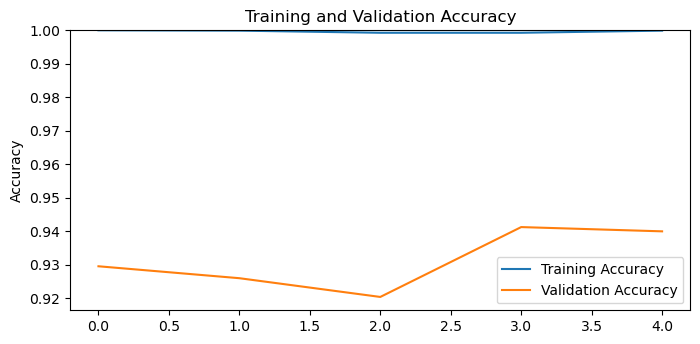

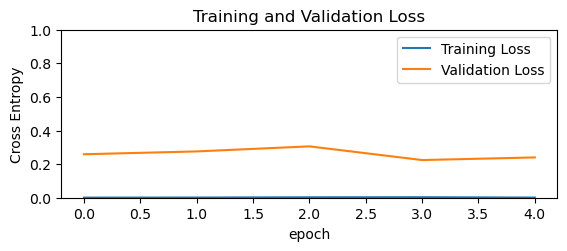

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Images

In [14]:
model = tf.keras.models.load_model('Fine_215EffNet_8_384')

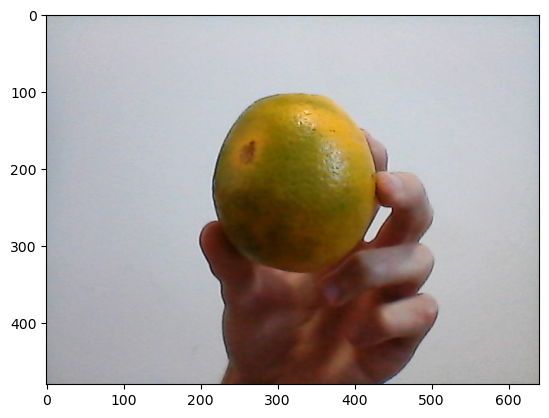

maca


In [42]:
image_path = 'C:\\Users\\marce\\OneDrive\\Documentos\\Code\\Dataset\\Test\\laranja-pera2.jpg' ####### ADICIONAR NOME IMAGEM #######

img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, size=(SIZE, SIZE))

yhat = model.predict(np.expand_dims(resize, 0), verbose=0)
prediction = np.argmax(yhat)
print(class_names[prediction])

# Keep training

In [14]:
model = tf.keras.models.load_model('Fine_215EffNet_8_384')

In [15]:
fine_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

EPOCHS = 10

history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data)

model_name = 'Fine-220EffNet_' + str(len(class_names)) + '_' + str(SIZE)
model.save(model_name)

Epoch 1/10


UnknownError: Graph execution error:

Detected at node 'sequential/efficientnetv2-s/stem_conv/Conv2D' defined at (most recent call last):
    File "d:\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "d:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "d:\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "d:\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "d:\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "d:\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "d:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "d:\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "d:\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "d:\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\marce\AppData\Local\Temp\ipykernel_16476\3588075169.py", line 8, in <module>
      history = model.fit(train_data,
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "d:\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/efficientnetv2-s/stem_conv/Conv2D'
CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4031): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node sequential/efficientnetv2-s/stem_conv/Conv2D}}]] [Op:__inference_train_function_116536]